## PART 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 1. Simple Moving Average (SMA)
def simple_moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 2. Gaussian Weighted Moving Average
def gaussian_kernel(size, std=1):
    kernel = np.exp(-0.5 * (np.arange(-size//2, size//2 + 1) / std)**2)
    return kernel / np.sum(kernel)

def gaussian_weighted_moving_average(data, window_size=10, std=1):
    kernel = gaussian_kernel(window_size, std)
    return np.convolve(data, kernel, mode='valid')

# 3. Low-Pass Butterworth Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# 4. Exponential Moving Average (EMA)
def exponential_moving_average(data, alpha=0.1):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

# function to denoise any data using one of the above methods
def denoise_data(data, method="SMA", **kwargs):
    if method == "SMA":
        return simple_moving_average(data, **kwargs)
    elif method == "Gaussian":
        return gaussian_weighted_moving_average(data, **kwargs)
    elif method == "Butterworth":
        return butter_lowpass_filter(data, cutoff=500, fs=10000, order=3, **kwargs)
    elif method == "EMA":
        return exponential_moving_average(data, **kwargs)
    else:
        raise ValueError("Method not recognized")



## Question 1: Quality Control with Noisy Measurements

True Means per Chunk: [np.float64(0.766), np.float64(0.751), np.float64(0.691), np.float64(0.659), np.float64(0.596), np.float64(0.577), np.float64(0.53), np.float64(0.471), np.float64(0.457), np.float64(0.42)]
Noisy Means per Chunk: [np.float64(0.704), np.float64(0.696), np.float64(0.649), np.float64(0.612), np.float64(0.576), np.float64(0.559), np.float64(0.535), np.float64(0.476), np.float64(0.47), np.float64(0.437)]


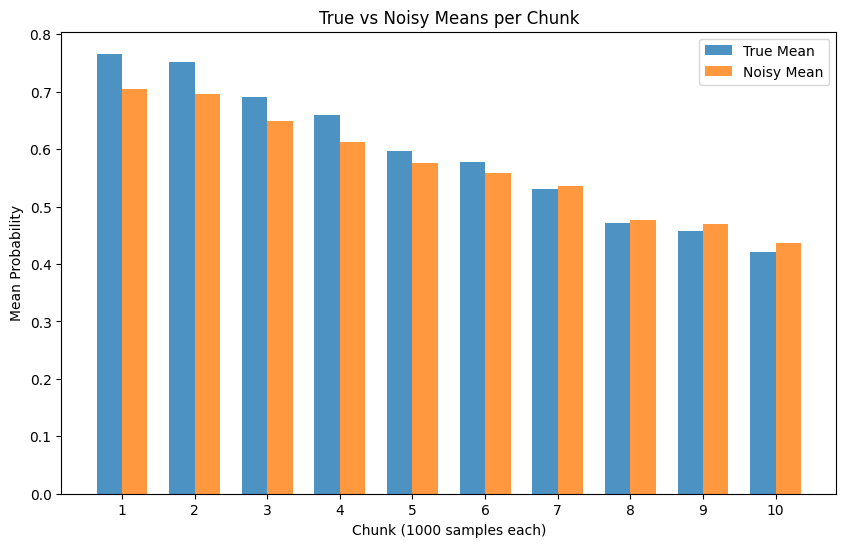

,Chunk,True Mean,Noisy Mean,Absolute Error
0,1,0.766,0.704,0.062
1,2,0.751,0.696,0.055
2,3,0.691,0.649,0.042
3,4,0.659,0.612,0.047
4,5,0.596,0.576,0.020
5,6,0.577,0.559,0.018
6,7,0.530,0.535,0.005
7,8,0.471,0.476,0.005
8,9,0.457,0.470,0.013
9,10,0.420,0.437,0.017


True Mean (Expected Probability): 0.59
Noisy Mean (Observed Probability with Noise): 0.57
Denoised Mean (Smoothed Probability): 0.57


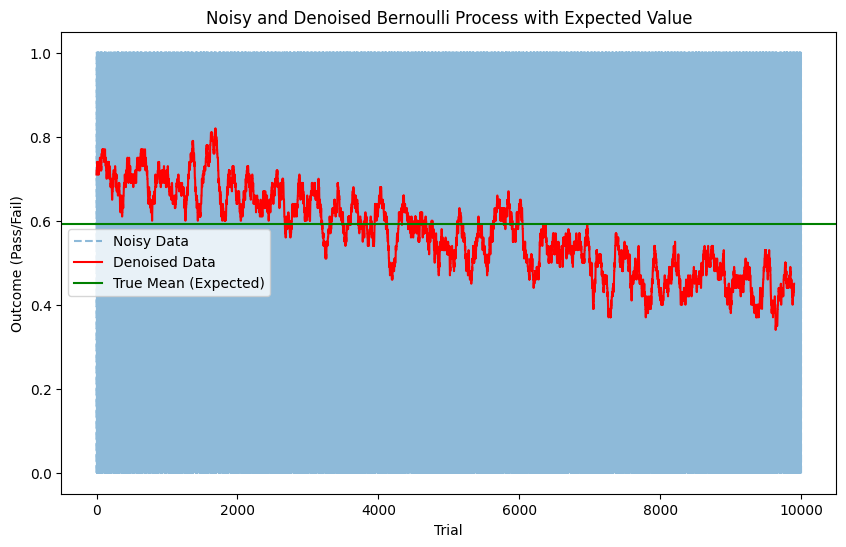

In [3]:
def simulate_noisy_bernoulli(p_start, p_end, n, noise_flip_prob=0.1):
    """
    Simulates a Bernoulli process with added noise by flipping a random subset of outcomes.
    
    Args:
        p (float): Probability of success for the Bernoulli trials.
        n (int): Number of trials.
        noise_flip_prob (float): Probability that a given outcome is flipped.

    Returns:
        tuple: (true outcomes, noisy outcomes)
    """
    # Linear drift in probability
    p_values = np.linspace(p_start, p_end, n)

    # Generate Bernoulli outcomes
    outcomes = np.random.binomial(1, p_values)

    # Randomly select indices to flip based on the noise flip probability
    num_flips = int(noise_flip_prob * n)
    flip_indices = np.random.choice(n, size=num_flips, replace=False)
    
    # Create a noisy copy of the outcomes and flip selected indices
    noisy_outcomes = outcomes.copy()
    noisy_outcomes[flip_indices] = 1 - noisy_outcomes[flip_indices]
    
    # Return true and noisy outcomes
    return outcomes, noisy_outcomes

# Parameters
p_start, p_end = 0.8, 0.4  # True probability of success
n = 10000  # Number of trials
noise_flip_prob = 0.1  # 10% noise flip probability

# Simulate the process
true_outcomes, noisy_outcomes = simulate_noisy_bernoulli(p_start, p_end, n, noise_flip_prob)

# Denoise the noisy outcomes (choose a method like "SMA", "Gaussian", etc.)
denoised_data = denoise_data(noisy_outcomes, method="SMA", window_size=100)  # Experiment with different methods

# Compute means
chunk_size = 1000
true_chunk_means = []
noisy_chunk_means = []

for i in range(10):
    start = i * chunk_size
    end = start + chunk_size
    true_chunk_means.append(true_outcomes[start:end].mean())
    noisy_chunk_means.append(noisy_outcomes[start:end].mean())
    
print("True Means per Chunk:", true_chunk_means)
print("Noisy Means per Chunk:", noisy_chunk_means)

chunks = np.arange(1, 11)

plt.figure(figsize=(10, 6))
width = 0.35

plt.bar(chunks - width/2, true_chunk_means, width=width, label="True Mean", alpha=0.8)
plt.bar(chunks + width/2, noisy_chunk_means, width=width, label="Noisy Mean", alpha=0.8)

plt.xlabel("Chunk (1000 samples each)")
plt.ylabel("Mean Probability")
plt.title("True vs Noisy Means per Chunk")
plt.xticks(chunks)
plt.legend()
plt.show()

df_results = pd.DataFrame({
    "Chunk": chunks,
    "True Mean": true_chunk_means,
    "Noisy Mean": noisy_chunk_means,
    "Absolute Error": np.abs(np.array(true_chunk_means) - np.array(noisy_chunk_means))
})

display(df_results)

true_mean = np.mean(true_outcomes)
noisy_mean = np.mean(noisy_outcomes)
denoised_mean = np.mean(denoised_data)

# Print results
print(f"True Mean (Expected Probability): {true_mean:.2f}")
print(f"Noisy Mean (Observed Probability with Noise): {noisy_mean:.2f}")
print(f"Denoised Mean (Smoothed Probability): {denoised_mean:.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(noisy_outcomes, alpha=0.5, label="Noisy Data", linestyle="--")
plt.plot(range(len(denoised_data)), denoised_data, label="Denoised Data", color="red")
plt.axhline(y=true_mean, color="green", linestyle="-", label="True Mean (Expected)")
plt.xlabel("Trial")
plt.ylabel("Outcome (Pass/Fail)")
plt.title("Noisy and Denoised Bernoulli Process with Expected Value")
plt.legend()
plt.show()


### 2. Temperature Trends with Noisy Measurements

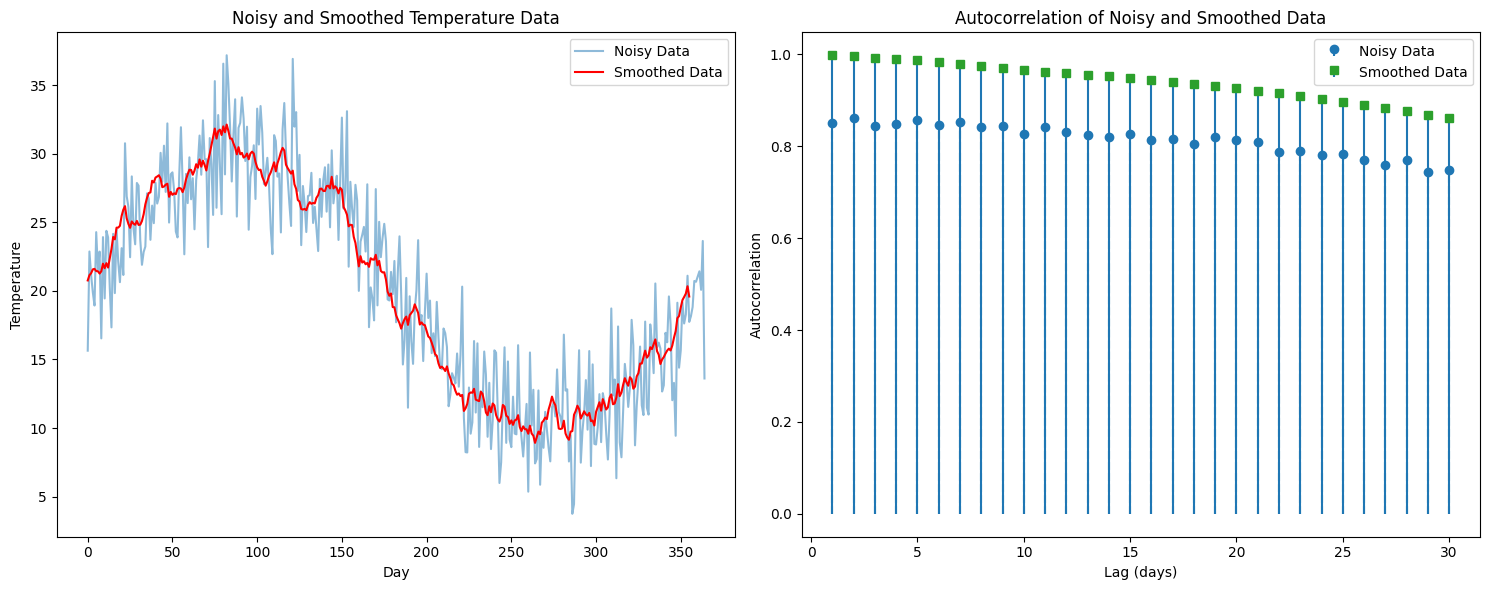

In [4]:
def generate_noisy_temperature(days, noise_level=3):
    """
    Generate a sinusoidal temperature signal with added noise.
    """
    base_temperature = 20 + 10 * np.sin(2 * np.pi * np.arange(days) / 365)
    noise = np.random.normal(0, noise_level, size=days)
    noisy_temperature = base_temperature + noise

    # Return noisy temperature data
    return noisy_temperature

def compute_autocorrelation(data, lag):
    """
    Compute autocorrelation for a given lag.
    """
    n = len(data)
    mean = np.mean(data)
    autocorr = np.sum((data[:n-lag] - mean) * (data[lag:] - mean)) / np.sum((data - mean) ** 2)

    # Return autocorrelation
    return autocorr

# Smooth temperature data
def smooth_temperature(data, method="SMA", **kwargs):
    """
    Apply smoothing using the chosen denoising method.
    """
    return denoise_data(data, method=method, **kwargs)

# Simulate noisy temperature data
days = 365
noise_level = 3  # Noise level
noisy_temperature = generate_noisy_temperature(days, noise_level)

# Denoise using the chosen method (e.g., SMA, Butterworth, etc.)
smoothed_temperature = smooth_temperature(noisy_temperature, method="SMA")


# Compute autocorrelations
lags = range(1, 31)

# Compute autocorrelations for noisy and smoothed data
noisy_autocorrelations = [compute_autocorrelation(noisy_temperature, lag) for lag in lags]

# Compute autocorrelations for smoothed data
smoothed_autocorrelations = [compute_autocorrelation(smoothed_temperature, lag) for lag in lags]


# Plot results
plt.figure(figsize=(15, 6))
# Plot temperature data
plt.subplot(1, 2, 1)
plt.plot(noisy_temperature, alpha=0.5, label="Noisy Data")
plt.plot(range(len(smoothed_temperature)), smoothed_temperature, label="Smoothed Data", color='red')
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.title("Noisy and Smoothed Temperature Data")
plt.legend()

# Plot autocorrelation
plt.subplot(1, 2, 2)
plt.stem(lags, noisy_autocorrelations, linefmt="--", markerfmt="o", basefmt=" ", label="Noisy Data")
plt.stem(lags, smoothed_autocorrelations, linefmt="-", markerfmt="s", basefmt=" ", label="Smoothed Data")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Noisy and Smoothed Data")
plt.legend()

plt.tight_layout()
plt.show()


### 3. Stationarity Analysis of an Audio Signal

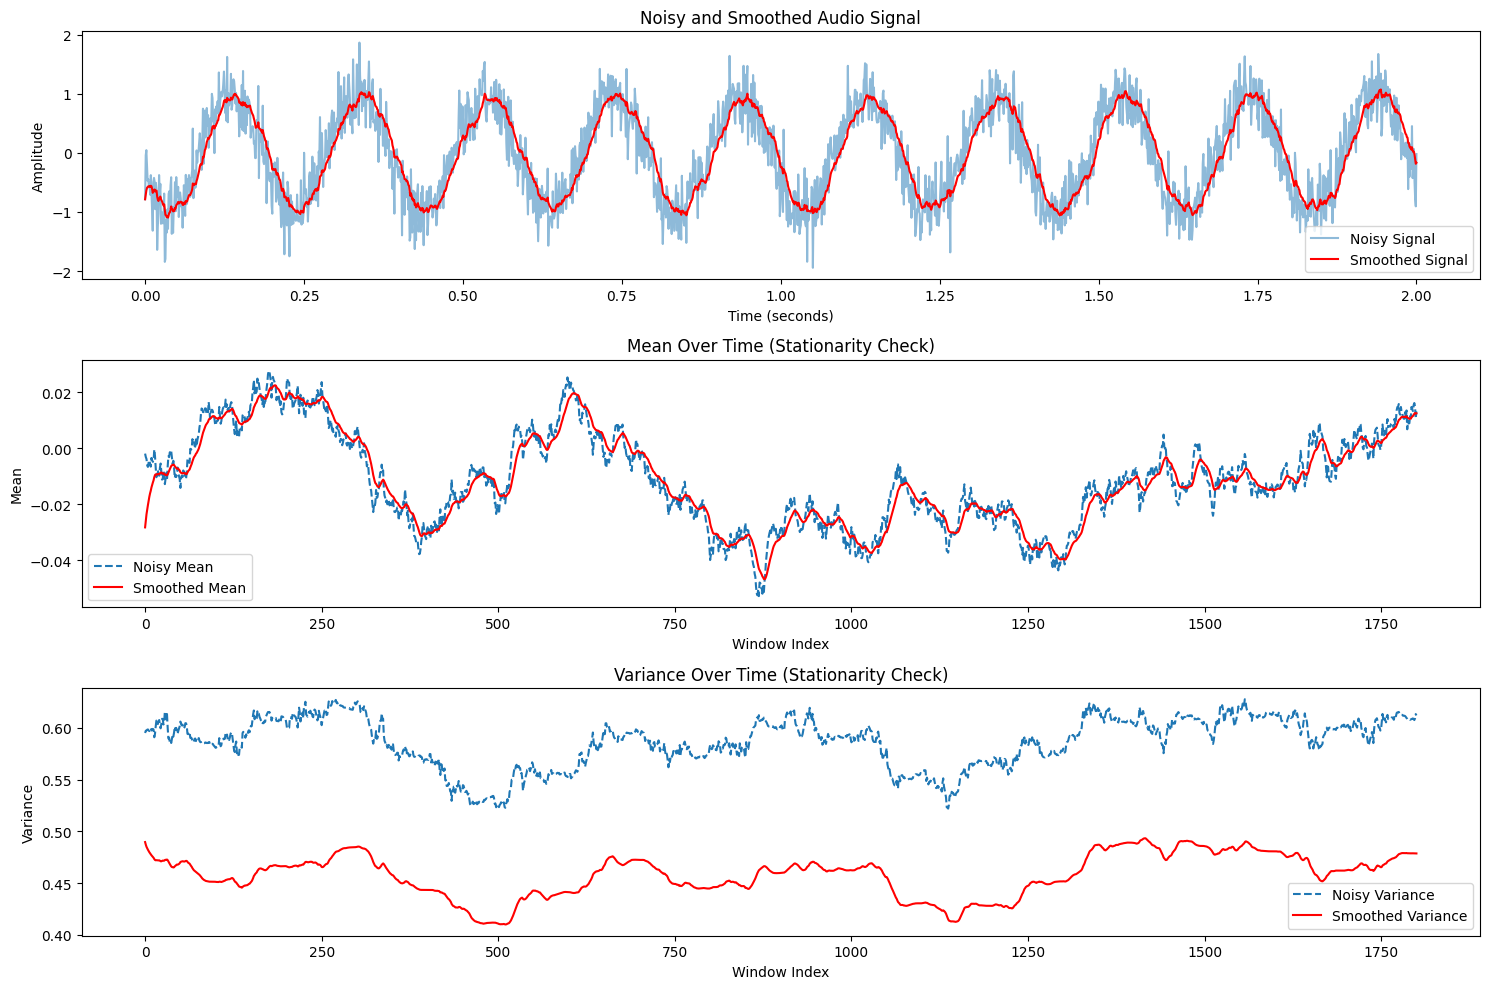

In [9]:
def generate_noisy_audio_signal(A, f, T, num_samples, noise_level=0.3):
    """
    Generate a noisy audio signal with a given amplitude and frequency.
    """
    t = np.linspace(0, T, num_samples)
    phi = np.random.uniform(0, 2 * np.pi)
    signal = A * np.cos(2 * np.pi * f * t + phi)
    noise = np.random.normal(0, noise_level, size=num_samples)
    return t, signal + noise

def check_stationarity(data, window_size):
    """
    Compute mean and variance over sliding windows to check stationarity.
    """
    means = []
    variances = []
    for i in range(0, len(data) - window_size + 1):
        window = data[i:i+window_size]  # Extract window
        means.append(np.mean(window))
        variances.append(np.var(window))
    
    # Return means and variances for stationarity check
    return means, variances

# Smooth noisy data
def smooth_audio_signal(data, method="Butterworth", **kwargs):
    """
    Apply smoothing using the chosen denoising method.
    """
    return denoise_data(data, method=method, **kwargs)

# Simulate noisy audio signal
A = 1.0            # Amplitude
f = 5              # Frequency in Hz
T = 2              # Total time in seconds

num_samples = 2000 # Number of samples
noise_level = 0.3  # Noise level

t, noisy_signal = generate_noisy_audio_signal(A, f, T, num_samples, noise_level)

# Apply smoothing
smoothed_signal = smooth_audio_signal(noisy_signal, method="EMA")

# Check stationarity
window_size = 200 # Window size for stationarity check
noisy_means, noisy_variances = check_stationarity(noisy_signal, window_size)
smoothed_means, smoothed_variances = check_stationarity(smoothed_signal, window_size)

# Plot results
plt.figure(figsize=(15, 10))

# Original signal
plt.subplot(3, 1, 1)
plt.plot(t[:len(noisy_signal)], noisy_signal, alpha=0.5, label="Noisy Signal")
plt.plot(t[:len(smoothed_signal)], smoothed_signal, label="Smoothed Signal", color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Noisy and Smoothed Audio Signal")
plt.legend()

# Mean plot
plt.subplot(3, 1, 2)
plt.plot(noisy_means, label="Noisy Mean", linestyle="--")
plt.plot(smoothed_means, label="Smoothed Mean", color='red')
plt.xlabel("Window Index")
plt.ylabel("Mean")
plt.title("Mean Over Time (Stationarity Check)")
plt.legend()

# Variance plot
plt.subplot(3, 1, 3)
plt.plot(noisy_variances, label="Noisy Variance", linestyle="--")
plt.plot(smoothed_variances, label="Smoothed Variance", color='red')
plt.xlabel("Window Index")
plt.ylabel("Variance")
plt.title("Variance Over Time (Stationarity Check)")
plt.legend()

plt.tight_layout()
plt.show()
